In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
import pickle
import PathSim as ps
import importlib
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model
import collections

Using Theano backend.


In [4]:
#########dataset and domain selection : sleep apnea: 0 ; obesity:1
importlib.reload(ut)
select_domain  = 1
domain = ['apnea','obesity']
root = '../linkPrediction/'
filepath=[['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv'],
        ['dataset/obesity-all,3.csv',
         'dataset/obesity-distinct_keyword.csv']]
########path to save graph files
graphpath=root+'graphs/'+domain[select_domain]
########path to save result files, data files and resultent figures
datapath=root+'dataframes/'+domain[select_domain]
#path to save classification models
modelpath=root+'models/'+domain[select_domain]
########columns with sub-columns
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_year, train:start_year, test:start_year, no_of_test_years(1), total_year_in_each_iteration, no of grandparents]
time=[2007,2008,2015,1,1,20]
times=[2007,2008,2015,1,1,20]
######load dataset and keyword list into dataframes
df, key_list = ut.load_dataset(filepath[select_domain], column_split)

In [335]:
# time=[1991,1992,1994,1,1,20]
importlib.reload(gr)
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)
# g_train, g_test = gr.graph_norm(root, domain, select_domain, g_train, g_test)

../linkPrediction/graphs/obesity\train_graph_2008.gpickle loaded, nodes: 2357 edges: 10285
../linkPrediction/graphs/obesity\train_graph_2009.gpickle loaded, nodes: 2092 edges: 10866
../linkPrediction/graphs/obesity\train_graph_2010.gpickle loaded, nodes: 2301 edges: 12449
../linkPrediction/graphs/obesity\train_graph_2011.gpickle loaded, nodes: 2402 edges: 14811
../linkPrediction/graphs/obesity\train_graph_2012.gpickle loaded, nodes: 2636 edges: 16683
../linkPrediction/graphs/obesity\train_graph_2013.gpickle loaded, nodes: 2635 edges: 16303
../linkPrediction/graphs/obesity\train_graph_2014.gpickle loaded, nodes: 3218 edges: 18244
../linkPrediction/graphs/obesity\test_graph_2015.gpickle loaded, nodes: 4040 edges: 21699
../linkPrediction/graphs/obesity\parent_graph_2007-2008.gpickle loaded, nodes: 2114 edges: 9587
../linkPrediction/graphs/obesity\train_graph_2008-2015.gpickle loaded, nodes: 4040 edges: 66648
../linkPrediction/graphs/obesity\test_graph_2015-2016.gpickle loaded, nodes: 4040

In [336]:
s_key={0:[9875,1020],1:[7614,9953]}
for t in range(2008,2015):
    g_train[t].remove_nodes_from(s_key[select_domain])
g_test[2015].remove_nodes_from(s_key[select_domain])
g_parent.remove_nodes_from(s_key[select_domain])
g_train_static.remove_nodes_from(s_key[select_domain])
g_test_static.remove_nodes_from(s_key[select_domain])

In [337]:
importlib.reload(ut)
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
test_data = ut.load_data(datapath, domain[select_domain], "test_data", time)
test_node = ut.load_data(datapath, domain[select_domain], "test_node", time)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge_list length:',len(edge_list))
print('test_data length:',len(test_data[2015]))
print('test_node length:',len(test_node[2015]))

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
train data length: 7
node feature length: 7
edge_list length: 131006
test_data length: 131006
test_node length: 4038


In [338]:
gps = list(test_node[2015][test_node[2015]['node_type_aut']==25]['node_index'])
ps = list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index'])

In [339]:
nx.density(g_test[2015])

0.0023741510394870236

In [340]:
nx_density = []
for a in range(20,0,-1):
    sublist = list(test_node[2015][test_node[2015]['node_type_aut']==25]['node_index'])
    del sublist[0:a]
    g = g_test[2015].copy()
    g.remove_nodes_from(sublist)
    nx_density.append(nx.density(g))
print(nx_density)
ut.save_data(nx_density, datapath, domain[select_domain], "nx_density_gp", times)   


nx_density = []
for a in range(403,0,-20):
    sublist = list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index'])
    del sublist[0:a]
    g = g_test[2015].copy()
    g.remove_nodes_from(sublist)
    nx_density.append(nx.density(g))
print(nx_density)
ut.save_data(nx_density, datapath, domain[select_domain], "nx_density_p", times)

[0.0023741510394870236, 0.002342676132788554, 0.002324064829176814, 0.002302363000001843, 0.0022534713305364606, 0.002234049252397876, 0.0022098085078735043, 0.0021854203126760166, 0.0021619930442258882, 0.002133982450471421, 0.00212012313112903, 0.002091076490519594, 0.0020765644429222474, 0.0020417865477939815, 0.0019965961131051127, 0.001980902204170871, 0.001961358759105447, 0.0019451362931673392, 0.0018960930604504226, 0.001880193025389232]
../linkPrediction/dataframes/obesity\obesity-nx_density_gp_2008-2015.pkl
[0.0021880029117615934, 0.0021666496137263858, 0.0021243717670527016, 0.002074664272849254, 0.002019233707503302, 0.001982250514152773, 0.0019497641076545282, 0.0018819410568261708, 0.0017799090652318675, 0.0017166509537427214, 0.0016452027340706772, 0.0015814109342938655, 0.0015056332264857543, 0.0013775623320895448, 0.0012952125303750401, 0.0012017187362956885, 0.0010969280510878046, 0.0010169136283245377, 0.0009174348206059024, 0.0007754850027379277, 0.00069226068976909

In [341]:
n_list =  list(test_node[2015][test_node[2015]['node_type_aut']==25]['node_index'])
g = g_test[2015].copy()
g.remove_nodes_from(n_list)
ds = sorted([d for n,d in g.degree()], reverse = True)
dc = collections.Counter(ds)
deg, cnt = zip(*dc.items())
deg_cnt = [deg,cnt]
ut.save_data(deg_cnt, datapath, domain[select_domain], "deg_cnt_gp", times)

n_list =  list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index'])
g = g_test[2015].copy()
g.remove_nodes_from(n_list)
ds = sorted([d for n,d in g.degree()], reverse = True)
dc = collections.Counter(ds)
deg, cnt = zip(*dc.items())
deg_cnt = [deg,cnt]
ut.save_data(deg_cnt, datapath, domain[select_domain], "deg_cnt_p", times)

../linkPrediction/dataframes/obesity\obesity-deg_cnt_gp_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-deg_cnt_p_2008-2015.pkl


In [342]:
importlib.reload(ut)

select_domain=0
datapath=root+'dataframes/'+domain[select_domain]
deg_cnt_gp_a = ut.load_data(datapath, domain[select_domain], "deg_cnt_gp", time)
deg_cnt_p_a = ut.load_data(datapath, domain[select_domain], "deg_cnt_p", time)
density_gp_a = ut.load_data(datapath, domain[select_domain], "nx_density_gp", time)
density_p_a = ut.load_data(datapath, domain[select_domain], "nx_density_p", time)

select_domain=1
datapath=root+'dataframes/'+domain[select_domain]
deg_cnt_gp_o = ut.load_data(datapath, domain[select_domain], "deg_cnt_gp", time)
deg_cnt_p_o = ut.load_data(datapath, domain[select_domain], "deg_cnt_p", time)
density_gp_o = ut.load_data(datapath, domain[select_domain], "nx_density_gp", time)
density_p_o = ut.load_data(datapath, domain[select_domain], "nx_density_p", time)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity


In [387]:
np.arange(0, 101, 5)
np.arange(0, len(density_p_a), 5)

array([ 0,  5, 10, 15, 20])

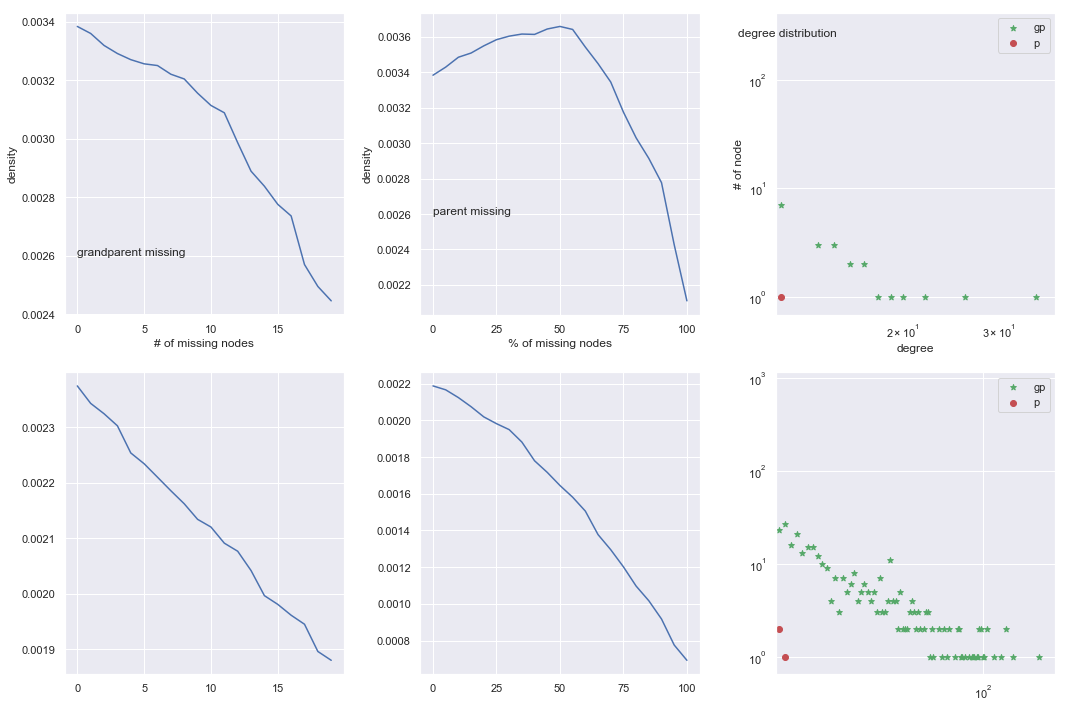

In [414]:
import seaborn as sns; sns.set(color_codes=True)
fig, axs = plt.subplots(2,3,figsize=(15,10))
title = ['$G_s$','$G_o$']
col=['g','r','b']

ax = axs[0][0]
ax.plot(density_gp_a)
ax.text(0,0.0026,"grandparent missing")
ax.set_xlabel("# of missing nodes")
ax.set_ylabel("density")
# ax.set_xscale("log")
# ax.set_yscale("log")

ax = axs[0][1]
ax.plot(density_p_a)
ax.text(0,0.0026,"parent missing")
ax.set_xticks(np.arange(0, len(density_p_a), 5))
ax.set_xticklabels(np.arange(0, 101, 25))
ax.set_xlabel("% of missing nodes")
ax.set_ylabel("density")

ax = axs[1][0]
ax.plot(density_gp_o)

ax = axs[1][1]
ax.plot(density_p_o)
ax.set_xticks(np.arange(0, len(density_p_o), 5))
ax.set_xticklabels(np.arange(0, 101, 25))

ax = axs[0][2]
# ax.set_xscale("log")
# ax.set_yscale("log")
plt.sca(ax)
ax.scatter(deg_cnt_gp_a[0],deg_cnt_gp_a[1],marker="*",c=col[0],label="gp")
ax.scatter(deg_cnt_p_a[0],deg_cnt_p_a[1],marker="o",c=col[1],label="p")
ax.text(10,250,"degree distribution")
ax.set_xlabel("degree")
ax.set_ylabel("# of node")
plt.legend(loc='best')

ax = axs[1][2]
plt.sca(ax)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.scatter(deg_cnt_gp_o[0],deg_cnt_gp_o[1],marker="*",c=col[0],label = "gp")
ax.scatter(deg_cnt_p_o[0],deg_cnt_p_o[1],marker="o",c=col[1],label="p")
plt.legend(loc='best')

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'density-degree'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

In [205]:
import numpy as np

def scale(X, x_min, x_max):
    nom = (X-X.min())*(x_max-x_min)
    denom = X.max() - X.min()
    denom = denom + (denom is 0)
    return x_min + nom/denom 

X = np.array([
    [ 0,  1],
    [ 2,  3],
    [ 4,  5],
    [ 6,  7],
    [ 8,  9],
    [10, 11],
    [12, 13],
    [14, 15]
])
X_scaled = scale(X, 0, 1)
print(X_scaled)

[[0.         0.06666667]
 [0.13333333 0.2       ]
 [0.26666667 0.33333333]
 [0.4        0.46666667]
 [0.53333333 0.6       ]
 [0.66666667 0.73333333]
 [0.8        0.86666667]
 [0.93333333 1.        ]]


In [206]:
feature_names = {
'author':[0],
'citation': [3]
}

times=[2007,2008,2015,1,1,20]
domain = ['apnea','obesity']

In [431]:
select_domain=0

importlib.reload(ut)

datapath=root+'dataframes/'+domain[select_domain]

train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
test_data = ut.load_data(datapath, domain[select_domain], "test_data", time)
test_node = ut.load_data(datapath, domain[select_domain], "test_node", time)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge_list length:',len(edge_list))
print('test_data length:',len(test_data[2015]))
print('test_node length:',len(test_node[2015]))

ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==25]['node_index']))
# ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index']))
eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] not in ps) and (ed[1] not in ps))]
n_eds = np.array(eds)

X_ap = ut.load_data(datapath, domain[select_domain], "X-features", times)
y_ap = ut.load_data(datapath, domain[select_domain], "y-features", times)
X_ap = X_ap[n_eds]
y_ap = y_ap[n_eds]

xx_a = X_ap[:,:,[0]] ##author
xx_a_gp = xx_a / np.linalg.norm(xx_a, ord=np.inf, axis=0, keepdims=True)
yy_a_gp = y_ap


#############################################################################################

# ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==25]['node_index']))
ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index']))
eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] not in ps) and (ed[1] not in ps))]
n_eds = np.array(eds)

X_ap = ut.load_data(datapath, domain[select_domain], "X-features", times)
y_ap = ut.load_data(datapath, domain[select_domain], "y-features", times)
X_ap = X_ap[n_eds]
y_ap = y_ap[n_eds]

xx_a = X_ap[:,:,[0]] ##author
xx_a_p = xx_a / np.linalg.norm(xx_a, ord=np.inf, axis=0, keepdims=True)
yy_a_p = y_ap

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
train data length: 7
node feature length: 7
edge_list length: 12494
test_data length: 12494
test_node length: 1093
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea


In [432]:
select_domain=1

datapath=root+'dataframes/'+domain[select_domain]

importlib.reload(ut)
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
test_data = ut.load_data(datapath, domain[select_domain], "test_data", time)
test_node = ut.load_data(datapath, domain[select_domain], "test_node", time)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge_list length:',len(edge_list))
print('test_data length:',len(test_data[2015]))
print('test_node length:',len(test_node[2015]))

ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==25]['node_index']))
# ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index']))
eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] not in ps) and (ed[1] not in ps))]
n_eds = np.array(eds)


X_ob = ut.load_data(datapath, domain[select_domain], "X-features", times)
y_ob = ut.load_data(datapath, domain[select_domain], "y-features", times)
X_ob = X_ob[n_eds]
y_ob = y_ob[n_eds]

xx_o = X_ob[:,:,[0]] ##author
xx_o_gp = xx_o / np.linalg.norm(xx_o, ord=np.inf, axis=0, keepdims=True)
yy_o_gp = y_ob


####################################################################################

# ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==25]['node_index']))
ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index']))
eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] not in ps) and (ed[1] not in ps))]
n_eds = np.array(eds)


X_ob = ut.load_data(datapath, domain[select_domain], "X-features", times)
y_ob = ut.load_data(datapath, domain[select_domain], "y-features", times)
X_ob = X_ob[n_eds]
y_ob = y_ob[n_eds]

xx_o = X_ob[:,:,[0]] ##author
xx_o_p = xx_o / np.linalg.norm(xx_o, ord=np.inf, axis=0, keepdims=True)
yy_o_p = y_ob


../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
train data length: 7
node feature length: 7
edge_list length: 131006
test_data length: 131006
test_node length: 4038
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity


In [433]:
print(len(xx_a_gp),len(xx_o_gp))
print(len(xx_a_p),len(xx_o_p))

11641 128115
4534 30665


In [434]:
neg_a_gp=np.array(xx_a_gp[yy_a_gp==0].flat)
pos_a_gp=np.array(xx_a_gp[yy_a_gp==1].flat)
neg_o_gp=np.array(xx_o_gp[yy_o_gp==0].flat)
pos_o_gp=np.array(xx_o_gp[yy_o_gp==1].flat)

neg_a_gp=neg_a_gp[neg_a_gp!=0]
pos_a_gp=pos_a_gp[pos_a_gp!=0]
neg_o_gp=neg_o_gp[neg_o_gp!=0]
pos_o_gp=pos_o_gp[pos_o_gp!=0]

##################################################

neg_a_p=np.array(xx_a_p[yy_a_p==0].flat)
pos_a_p=np.array(xx_a_p[yy_a_p==1].flat)
neg_o_p=np.array(xx_o_p[yy_o_p==0].flat)
pos_o_p=np.array(xx_o_p[yy_o_p==1].flat)

neg_a_p=neg_a_p[neg_a_p!=0]
pos_a_p=pos_a_p[pos_a_p!=0]
neg_o_p=neg_o_p[neg_o_p!=0]
pos_o_p=pos_o_p[pos_o_p!=0]

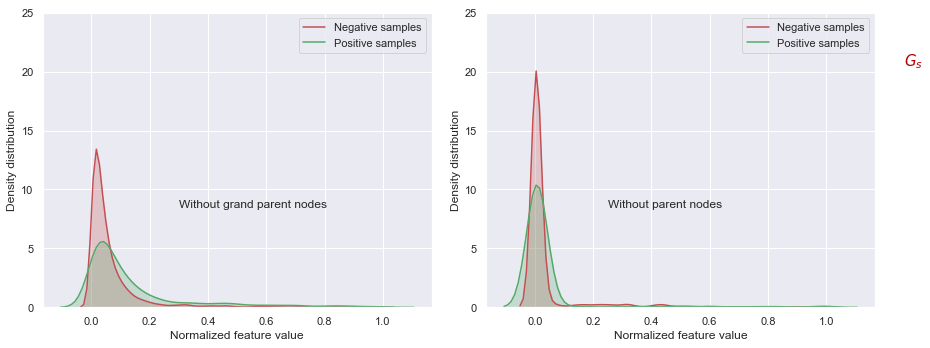

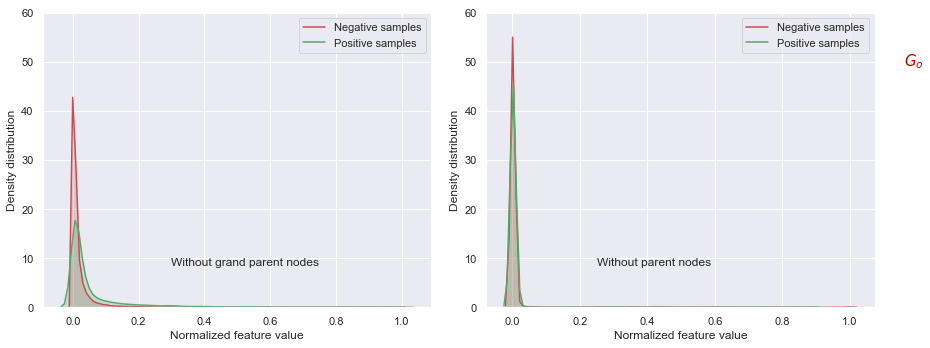

In [456]:
import seaborn as sns; sns.set(color_codes=True)
fig, axs = plt.subplots(1,2,figsize=(13,5))
title = ['$G_s$','$G_o$']
k='gau'
b=0.0001

ax=axs[0]
plt.sca(ax)
sns.kdeplot(neg_a_gp, shade=True, color="r",label='Negative samples', ax=axs[0],kernel=k)
sns.kdeplot(pos_a_gp, shade=True, color="g",label='Positive samples', ax=axs[0],kernel=k)
ax.text(.3,8.5,'Without grand parent nodes')
plt.ylim(0,25)
plt.ylabel("Density distribution",fontsize=12)
plt.xlabel("Normalized feature value",fontsize=12)



ax=axs[1]
plt.sca(ax)
sns.kdeplot(neg_a_p, shade=True, color="r",label='Negative samples',  ax=axs[1],kernel=k)
sns.kdeplot(pos_a_p, shade=True, color="g", label='Positive samples',ax=axs[1],kernel=k)
ax.text(.25,8.5,'Without parent nodes')
plt.ylim(0,25)
plt.ylabel("Density distribution",fontsize=12)
plt.xlabel("Normalized feature value",fontsize=12)
plt.title(title[0], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'p-gp-minus_distribution'+"-apnea-" +".pdf")
plt.savefig(fig_file_name)
plt.show()


fig, axs = plt.subplots(1,2,figsize=(13,5))
title = ['$G_s$','$G_o$']
k='gau'
b=0.0001

ax=axs[0]
plt.sca(ax)
sns.kdeplot(neg_o_gp, shade=True, color="r",label='Negative samples', ax=axs[0],kernel=k)
sns.kdeplot(pos_o_gp, shade=True, color="g",label='Positive samples', ax=axs[0],kernel=k)
ax.text(.3,8.5,'Without grand parent nodes')
plt.ylim(0,60)
plt.ylabel("Density distribution",fontsize=12)
plt.xlabel("Normalized feature value",fontsize=12)



ax=axs[1]
plt.sca(ax)
sns.kdeplot(neg_o_p, shade=True, color="r",label='Negative samples',  ax=axs[1],kernel=k)
sns.kdeplot(pos_o_p, shade=True, color="g", label='Positive samples',ax=axs[1],kernel=k)
ax.text(.25,8.5,'Without parent nodes')
plt.ylim(0,60)
plt.ylabel("Density distribution",fontsize=12)
plt.xlabel("Normalized feature value",fontsize=12)
plt.title(title[1], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'p-gp-minus_distribution'+"-obesity-" +".pdf")
plt.savefig(fig_file_name)
plt.show()



In [9]:
!pip install update matplotlib

../linkPrediction/dataframes/apnea


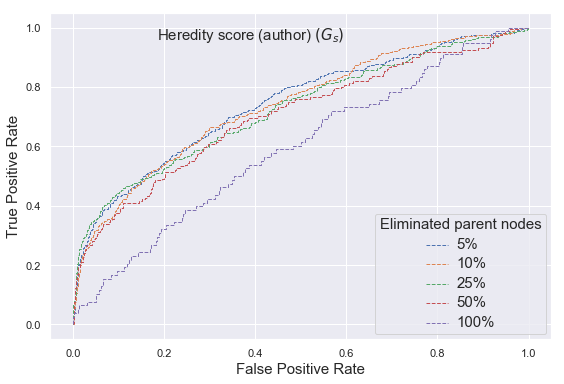

../linkPrediction/dataframes/obesity


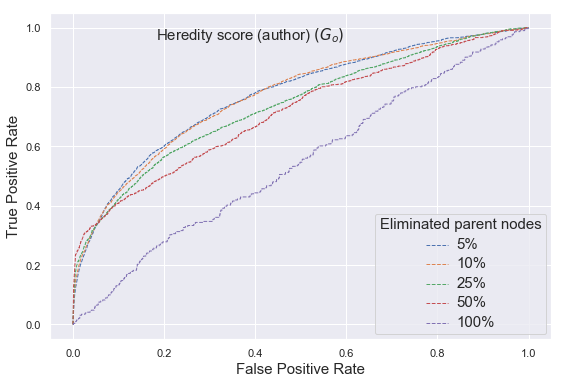

In [54]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1,figsize=(8,5.5))
title = ['$G_s$','$G_o$']
#0:0, 1:1, 2:5, 3:10, 4:15, 5:20, 6;25, 7:50, 8:100
ind = [2,3,6,7,8]
select_domain=0
datapath=root+'dataframes/'+domain[select_domain]
#apnea
results = ut.load_data(datapath, domain[select_domain], "results-v", times)

ax = axs
plt.sca(ax)
for i,row in enumerate(results):
    if i in ind:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,
                 label =row['model name'][7:]+ "%")

legend= plt.legend(loc='lower right',title='Eliminated parent nodes', fancybox=True)
legend.get_title().set_fontsize('15') #legend 'Title' fontsize
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize
plt.title("Heredity score (author) $(G_{s})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,"roc-parent eliminated-author-"+"apnea-" +".pdf")
plt.savefig(fig_file_name)
plt.show()

select_domain=1
datapath=root+'dataframes/'+domain[select_domain]
#obesity
results = ut.load_data(datapath, domain[select_domain], "results-v", times)


fig, axs = plt.subplots(1,1,figsize=(8,5.5))
ax = axs
plt.sca(ax)
for i,row in enumerate(results):
    if i in ind:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,label = row['model name'][7:]+ "%")
legend= plt.legend(loc='lower right',title='Eliminated parent nodes', fancybox=True)
legend.get_title().set_fontsize('15') #legend 'Title' fontsize
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize
plt.title("Heredity score (author) $(G_{o})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,"roc-parent eliminated-author-"+"obesity" +".pdf")
plt.savefig(fig_file_name)
plt.show()

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


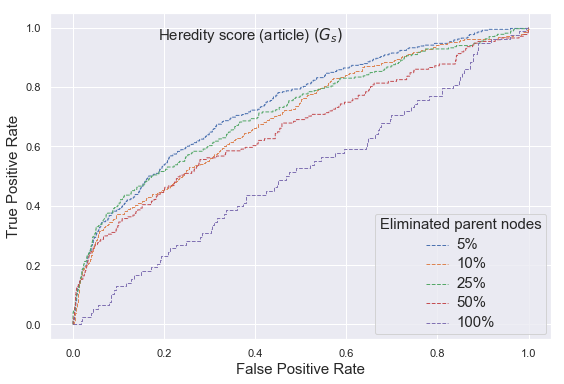

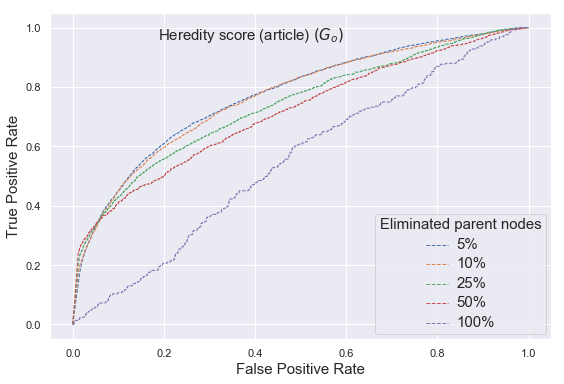

In [55]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1,figsize=(8,5.5))
title = ['$G_s$','$G_o$']
#0:0, 1:1, 2:5, 3:10, 4:15, 5:20, 6;25, 7:50, 8:100
ind = [2,3,6,7,8]
select_domain=0
datapath=root+'dataframes/'+domain[select_domain]
#apnea
results = ut.load_data(datapath, domain[select_domain], "results-article-", times)

ax = axs
plt.sca(ax)
for i,row in enumerate(results):
    if i in ind:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,
                 label =row['model name'][8:]+ "%")

legend= plt.legend(loc='lower right',title='Eliminated parent nodes', fancybox=True)
legend.get_title().set_fontsize('15') #legend 'Title' fontsize
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize
plt.title("Heredity score (article) $(G_{s})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)

select_domain=1
datapath=root+'dataframes/'+domain[select_domain]
#obesity
results = ut.load_data(datapath, domain[select_domain], "results-article-", times)

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,"roc-parent eliminated-article-" +"-apnea"+".pdf")
plt.savefig(fig_file_name)
plt.show()

fig, axs = plt.subplots(1,1,figsize=(8,5.5))
ax = axs
plt.sca(ax)
for i,row in enumerate(results):
    if i in ind:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,label = row['model name'][8:]+ "%")
legend= plt.legend(loc='lower right',title='Eliminated parent nodes', fancybox=True)
legend.get_title().set_fontsize('15') #legend 'Title' fontsize
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize
plt.title("Heredity score (article) $(G_{o})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,"roc-parent eliminated-article-"+"-obesity" +".pdf")
plt.savefig(fig_file_name)
plt.show()